# LLM ModelTest #3

##### *Alibaba-NLP/gte-multilingual-base*

In [ ]:
# API KEY를 환경변수로 관리하기 위한 설정 파일
from dotenv import load_dotenv
import os

# API KEY 정보로드
load_dotenv()
GEMINI_API_KEY = os.getenv('API_KEY_GEMINI')

In [ ]:
# LangSmith 추적을 설정합니다. https://smith.langchain.com
# !pip install langchain-teddynote
from langchain_teddynote import logging

# 프로젝트 이름을 입력합니다.
logging.langsmith("lgdx_team2")

In [ ]:
from langchain_community.embeddings import HuggingFaceEmbeddings
from langchain_community.document_loaders.csv_loader import CSVLoader

from langchain_community.vectorstores import Chroma

from langchain.schema import Document
from langchain.text_splitter import RecursiveCharacterTextSplitter

import pandas as pd

# 랭체인 환경 설정
from langchain_core.runnables import RunnablePassthrough
from langchain_core.output_parsers import StrOutputParser
from langchain.prompts import ChatPromptTemplate
from langchain_google_genai import ChatGoogleGenerativeAI

In [ ]:
### 01. CSV 파일에서 문서 로드 ###
loader = CSVLoader('../data/movie_4000_preprocessed.csv', encoding='utf8')
docs = loader.load()
print(f"문서의 수: {len(docs)}")

### 02. pandas로 데이터프레임 칼럼명 가져오기
csv_path = '../data/movie_4000_preprocessed.csv'
df = pd.read_csv(csv_path, encoding='utf8')
colnames = df.columns

In [ ]:
### 03. 메타데이터 추가 ###
docs = []
for _, row in df.iterrows():
  # 필요한 메타데이터 설정
  metadata = {
    'title': row['movie_title'],
    'genre': row['genre']
  }
  # 각 행의 데이터를 문서로 변환
  doc = Document(
    page_content=str(row.to_dict()),
    metadata=metadata
  )
  docs.append(doc)

print(f"문서의 수: {len(docs)}")
print('[메타데이터 예시]\n', docs[100].metadata)

In [ ]:
### 04. 데이터 청크 나누기 ###
text_splitter = RecursiveCharacterTextSplitter(
  chunk_size=1090, chunk_overlap=0
)
splits = text_splitter.split_documents(docs)
print("split된 문서의 수:", len(splits))

In [ ]:
### 05. 임베딩 모델 생성
# https://huggingface.co/ibm-granite/granite-embedding-278m-multilingual
embeddings = HuggingFaceEmbeddings(model_name='Alibaba-NLP/gte-multilingual-base',
                                   model_kwargs={"trust_remote_code": True}
)

# trust_remote_code: True를 하는 이유는?
# 모델의 설정 파일에 있는 커스텀 로직이 로컬 환경에서 실행될 수 있도록 허용하는 것 (이 모델에 반드시 필요한 옵션)

In [ ]:
### 06. 벡터스토어 생성 ###
DB_PATH = './movie_4000_vectorstore_3'

## Chroma
# vectorstore = Chroma.from_documents(
#   documents=splits,
#   embedding=embeddings,
#   persist_directory=DB_PATH,
# )
# print("벡터스토어 저장 완료!")

In [ ]:
# Chroma 벡터스토어 로드
vectorstore = Chroma(persist_directory="./movie_4000_vectorstore_3", embedding_function=embeddings)

<br><hr>

In [ ]:
### 03. 랭체인 구성 ###
# 검색기 생성
retriever = vectorstore.as_retriever(
    search_type="mmr",   
    search_kwargs={"k": 20,              # 반환할 문서 수 (default: 4)
                   "fetch_k": 50,       # MMR 알고리즘에 전달할 문서 수
                   "lambda_mult": 0.5,    # 결과 다양성 조절 (default: 0.5),
                   }
)

# 프롬프트 템플릿 설정
template = """
You are a movie-recommendation chatbot.
You must only answer based on the given context.
Do not generate answers that are not directly supported by the context.

[Context]:
{retrieved_context}

[Question]:
{query}

[Answer]:
"""
prompt = ChatPromptTemplate.from_template(template)

# Google Gemini 모델 생성
def load_gemini(system_instruction):
    model = ChatGoogleGenerativeAI(
        model='gemini-1.5-flash',
        temperature=0.3,
        max_tokens=5000,
        system_instruction=system_instruction,
        api_key=GEMINI_API_KEY
    )
    print(">>>>>>> model loaded...")
    return model

system_instruction = """you are a movie-recommendation chatbot. you must answer based on given data."""
llm = load_gemini(system_instruction)

In [ ]:
# langchain 체인 구성
rag_chain = (
  {"query":RunnablePassthrough(),
    "retrieved_context": retriever,
  }
  # question(사용자의 질문) 기반으로 연관성이 높은 문서 retriever 수행 >> format_docs로 문서를 하나로 만듦
  | prompt               # 하나로 만든 문서를 prompt에 넘겨주고
  | llm                  # llm이 원하는 답변을 만듦
  | StrOutputParser()
)

In [ ]:
### 04. 모델 테스트 ###
user_query='호러 장르의 영화를 추천해줘'
response = rag_chain.invoke(user_query)
print(response)

<br><br><hr>

# 시각화

In [108]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# 한글 font 설정
import platform
import matplotlib.font_manager as fm

#matplotlib 패키지 한글 깨짐 처리 시작
#------------------------------------------------------------------------------------
# 운영체제별 한글 폰트 설정

if platform.system() == 'Darwin': # Mac 환경 폰트 설정
    plt.rc('font', family='AppleGothic')
elif platform.system() == 'Windows': # Windows 환경 폰트 설정
    plt.rc('font', family='Malgun Gothic')
    
plt.rcParams['axes.unicode_minus'] = False #한글 폰트 사용시 마이너스 폰트 깨짐 해결

# 글씨 선명하게 출력하는 설정

from IPython.display import set_matplotlib_formats
set_matplotlib_formats("retina")

C:\Users\USER\AppData\Local\Temp\ipykernel_18944\1455976250.py:23: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  set_matplotlib_formats("retina")


In [109]:
latency = pd.read_csv("./results/latency.csv", encoding='utf8')
print(latency.shape)
tokensize = pd.read_csv("./results/token_size.csv", encoding='utf8')
print(tokensize.shape)

(3, 6)
(3, 6)


In [110]:
tokensize

,models,Q1,Q2,Q3,Q4,Q5
0,model 1,5167,6050,4931,4709,3764
1,model 2,3655,4199,4856,3847,4286
2,model 3,5057,5178,6075,5506,5927


In [111]:
latency_melted = latency.melt(id_vars="models", var_name="Question", value_name="Latency")
tokensize_melted = tokensize.melt(id_vars="models", var_name="Question", value_name="Token Size")

tokensize_melted

,models,Question,Token Size
0,model 1,Q1,5167
1,model 2,Q1,3655
2,model 3,Q1,5057
3,model 1,Q2,6050
4,model 2,Q2,4199
5,model 3,Q2,5178
6,model 1,Q3,4931
7,model 2,Q3,4856
8,model 3,Q3,6075
9,model 1,Q4,4709


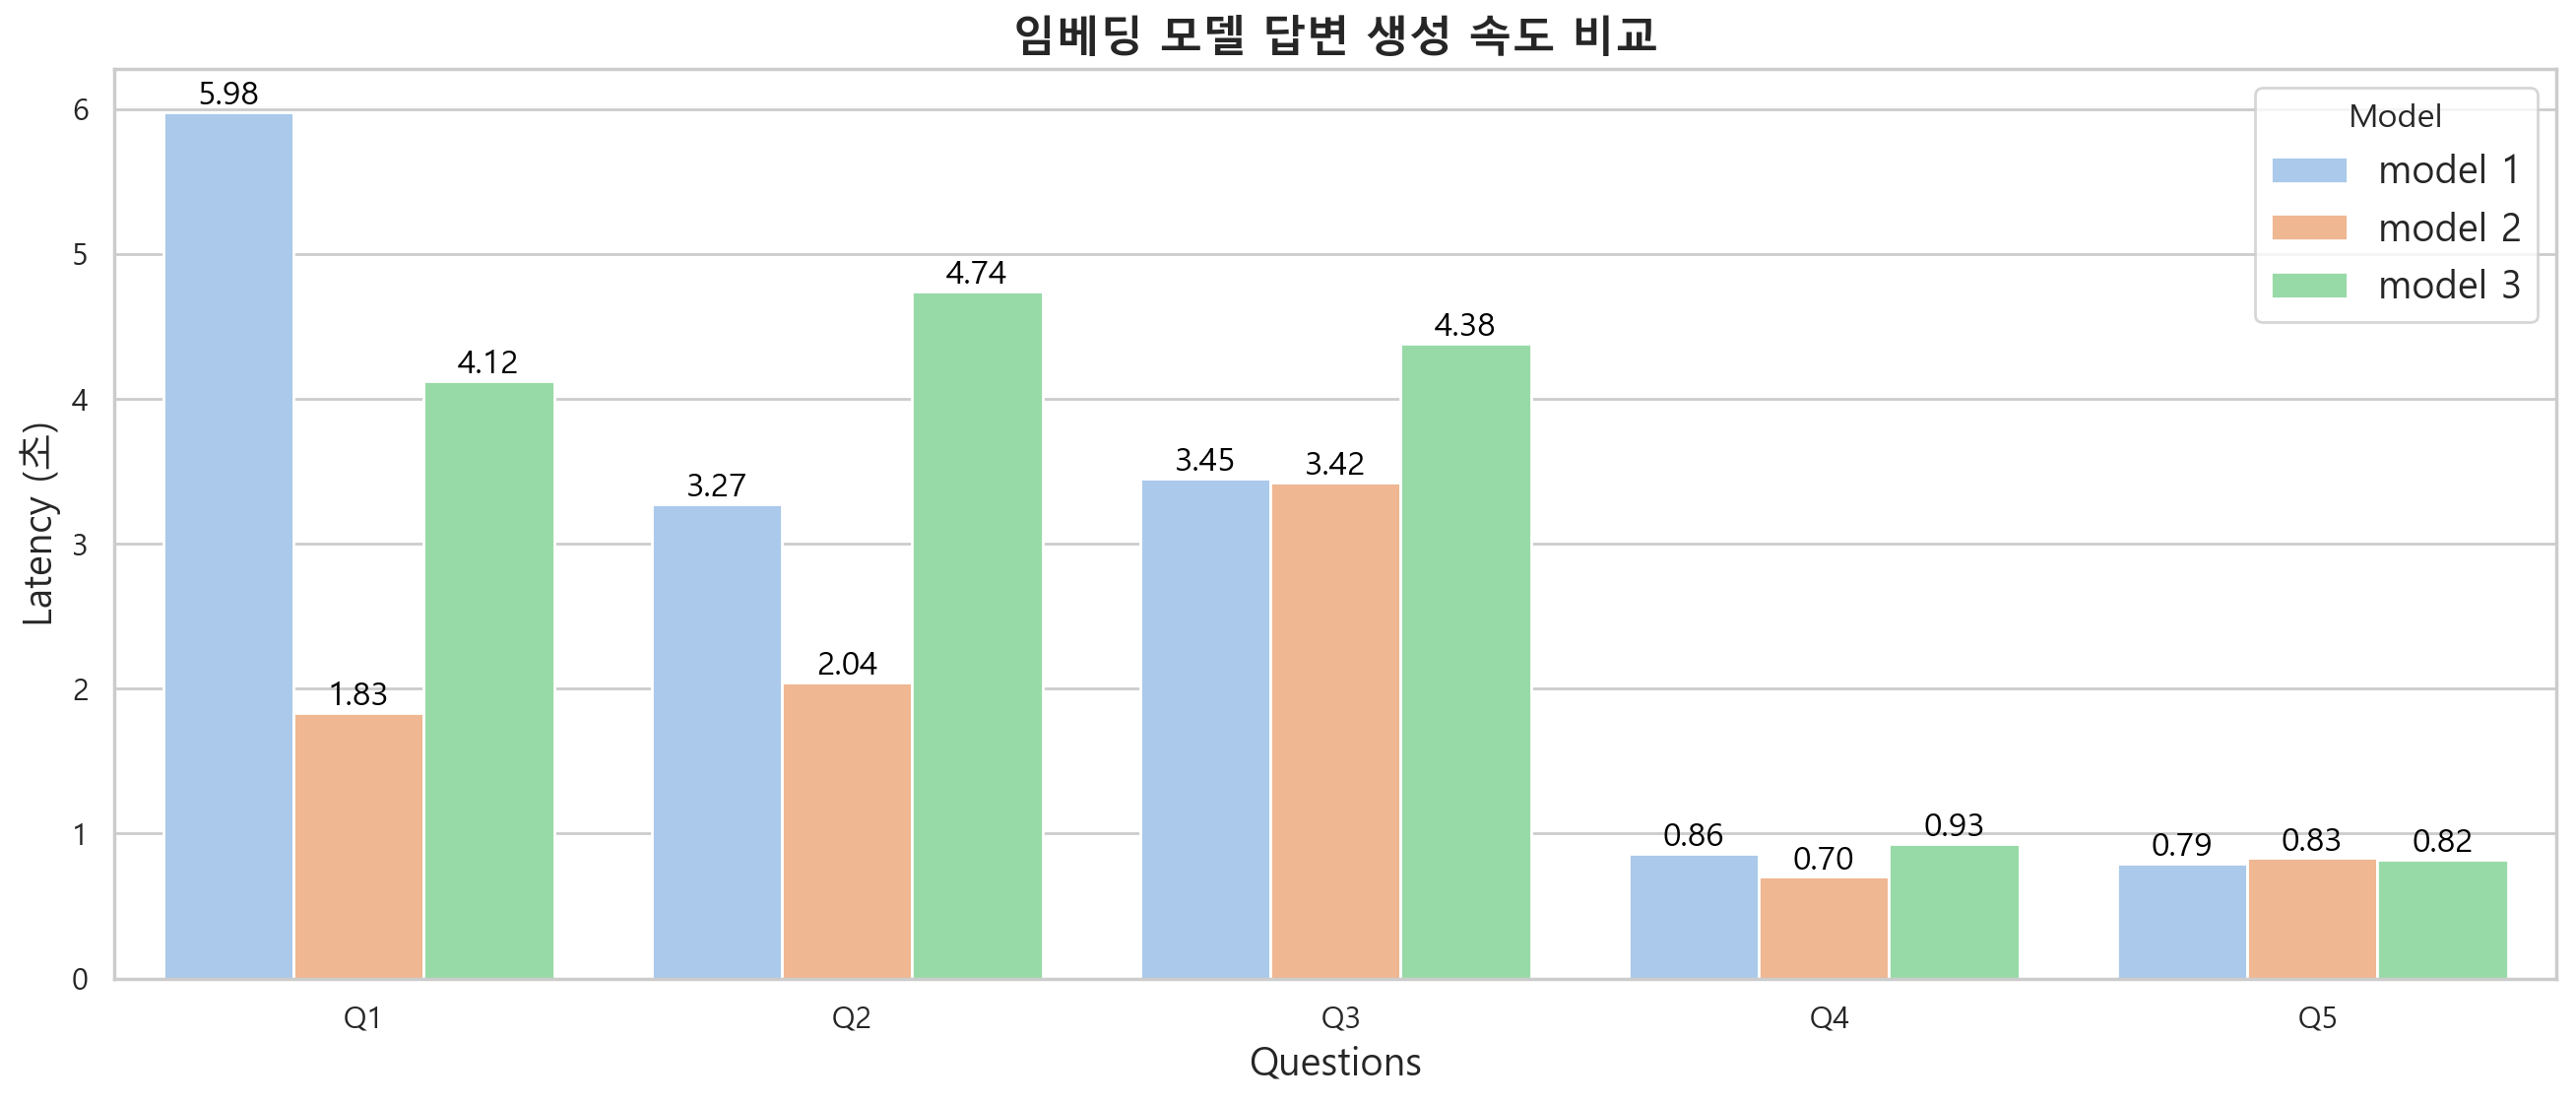

In [113]:
# 시각화
sns.set_theme(
    context='notebook',
    style='whitegrid',
    palette='pastel',
    font='Malgun Gothic'
)
plt.figure(figsize=(16, 6))
ax = sns.barplot(data=latency_melted, x="Question", y="Latency", hue="models")

# 막대 위에 수치 출력
for p in ax.patches:
    height = p.get_height()
    if height > 0:
        ax.annotate(f"{height:.2f}", 
                    (p.get_x() + p.get_width() / 2., height), 
                    ha='center', va='bottom', fontsize=12, color='black')


# 그래프 설정
plt.title("임베딩 모델 답변 생성 속도 비교", fontdict = {'fontsize' : 16, 'fontweight':'bold'})
plt.xlabel("Questions", fontdict = {'fontsize' : 14})
plt.ylabel("Latency (초)", fontdict = {'fontsize' : 14})
plt.legend(title="Model", fontsize=14)
plt.show()

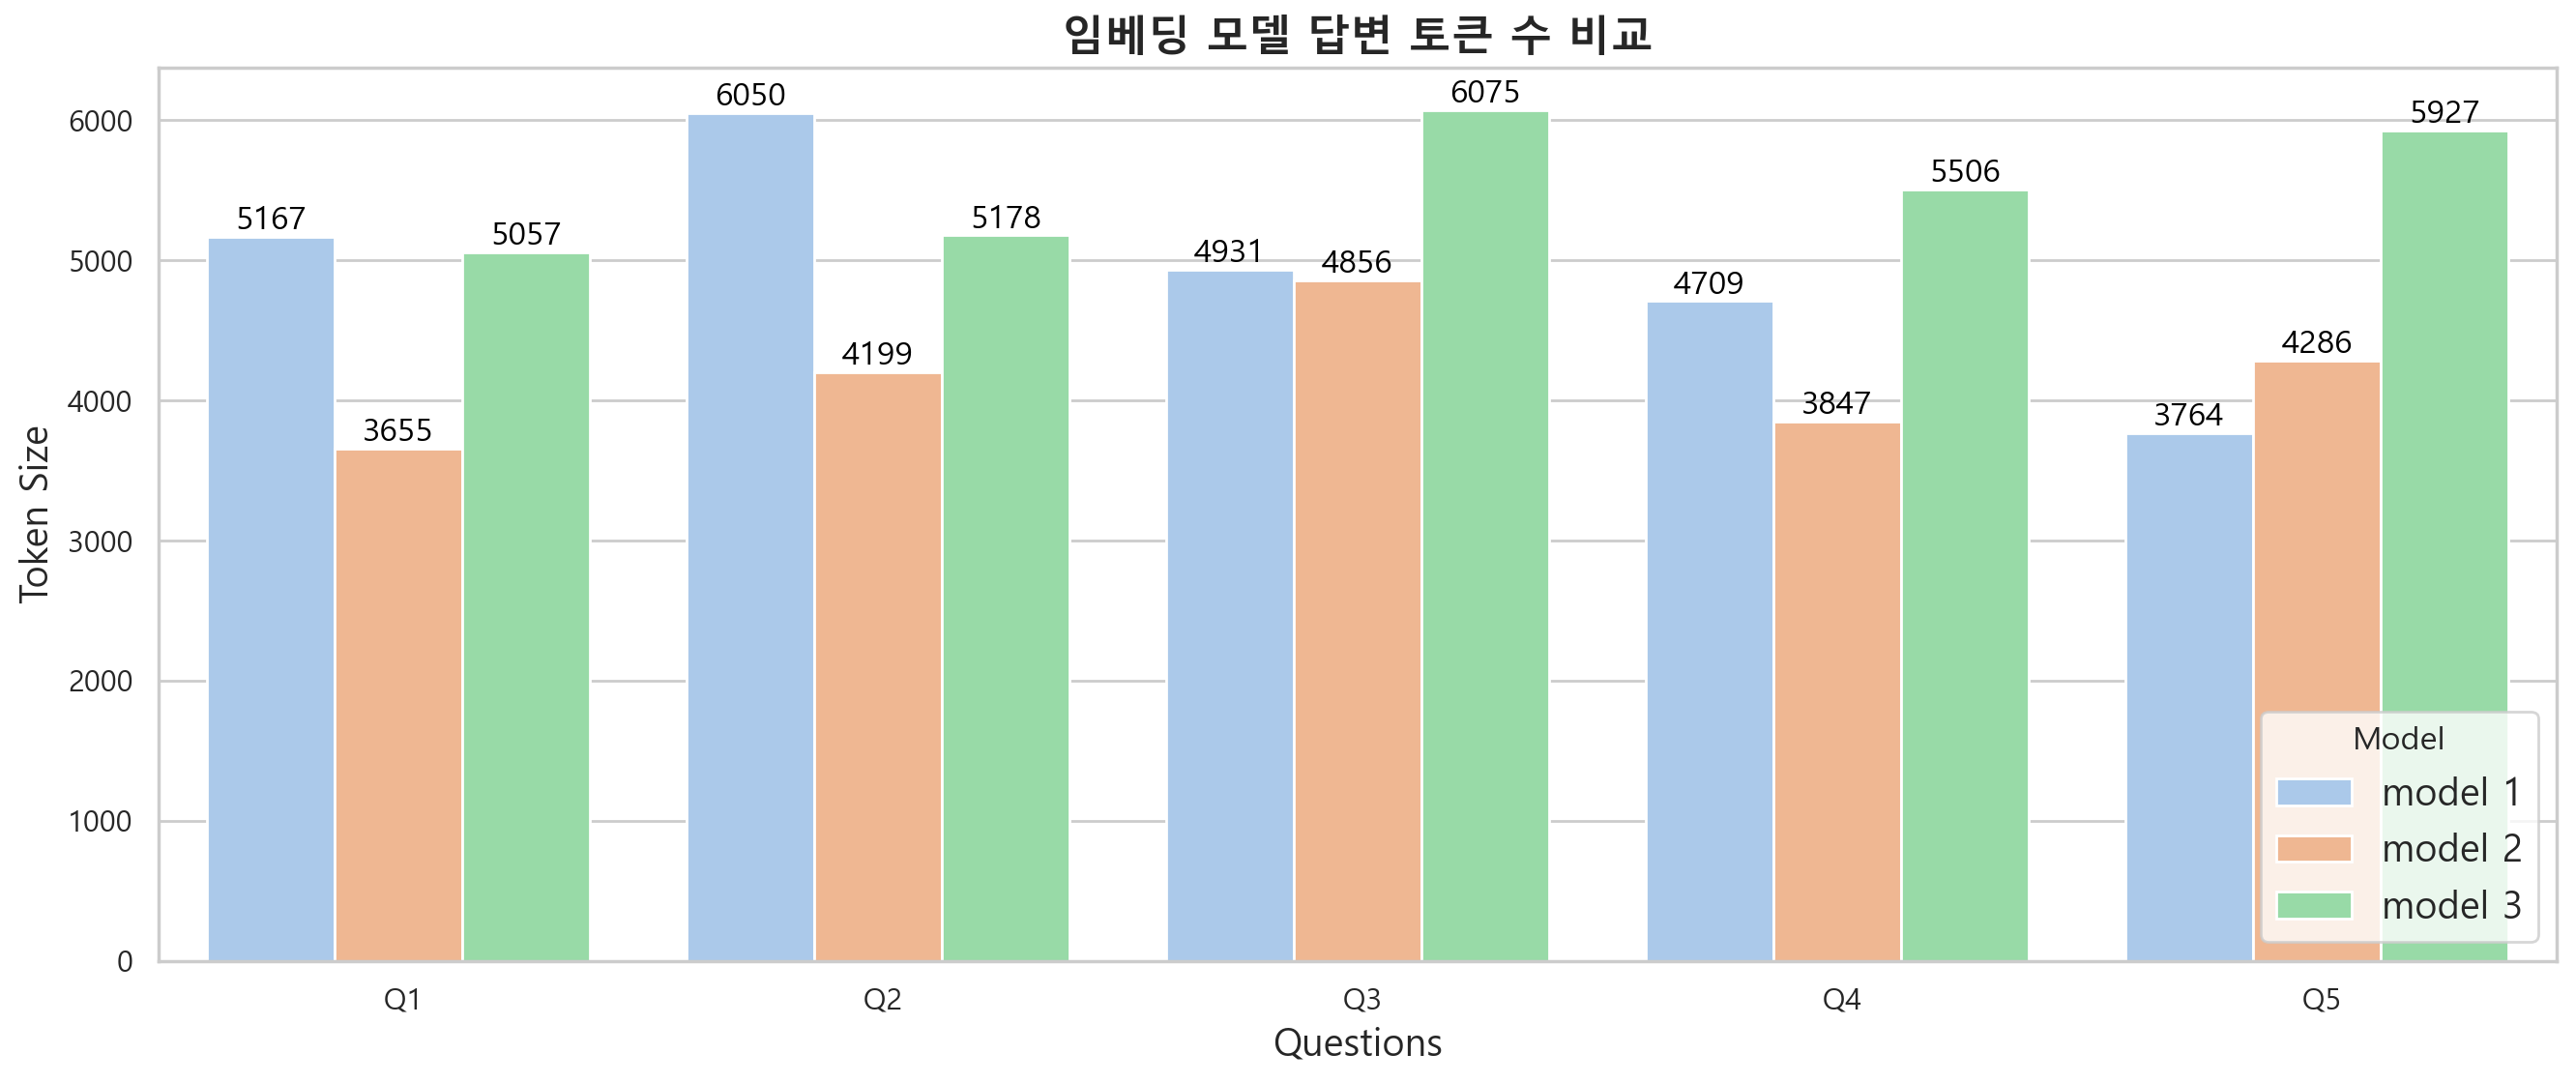

In [119]:
# 시각화
sns.set_theme(
    context='notebook',
    style='whitegrid',
    palette='pastel',
    font='Malgun Gothic'
)
plt.figure(figsize=(16, 6))
ax = sns.barplot(data=tokensize_melted, x="Question", y="Token Size", hue="models")

# 막대 위에 수치 출력
for p in ax.patches:
    height = p.get_height()
    if height > 0:
        ax.annotate(f"{height:.0f}", 
                    (p.get_x() + p.get_width() / 2., height), 
                    ha='center', va='bottom', fontsize=12, color='black')


# 그래프 설정
plt.title("임베딩 모델 답변 토큰 수 비교", fontdict = {'fontsize' : 16, 'fontweight':'bold'})
plt.xlabel("Questions", fontdict = {'fontsize' : 14})
plt.ylabel("Token Size", fontdict = {'fontsize' : 14})
plt.legend(title="Model", fontsize=14, loc='lower right')
plt.show()